# SETUP
- - -

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Dejavu Sans"

import seaborn as sns
sns.set()

%matplotlib inline

In [ ]:
!ls /Users/quartz/data/IOT_data/

In [ ]:
file_path = '/Users/quartz/data/iot-data/cansim-0800020-eng-6674700030567901031.csv'

In [ ]:
data_raw = pd.read_csv(file_path, skiprows=6, skipfooter=9)
data_raw.head()

In [ ]:
data_raw.dtypes

In [ ]:
# 월별 끝일 삽일

from pandas.tseries.offsets import MonthEnd

# data_raw['Adjustments'] = 
data_raw.Adjustments = pd.to_datetime(data_raw['Adjustments']) + MonthEnd(1)
data_raw = data_raw.set_index('Adjustments')
data_raw.head()

### Plotting

In [ ]:
# 기준점 형성(Timestamp)
split_date = pd.Timestamp('01-01-2011')

# Unadjusted feature만 활용해서 dataframe을 만든다
train = data_raw.loc[:split_date, ['Unadjusted']]
test = data_raw.loc[split_date:, ['Unadjusted']]

print(split_date, train.shape, test.shape)

# plot

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

### preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

train_sc_df = pd.DataFrame(data=train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(data=test_sc, columns=['Scaled'], index=test.index)

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

train_sc_df.head()

In [ ]:
for shift in range(1, 13):
    train_sc_df['shift_{}'.format(shift)] = train_sc_df['Scaled'].shift(shift)
    test_sc_df['shift_{}'.format(shift)] = test_sc_df['Scaled'].shift(shift)

In [ ]:
train_sc_df.head(20)

In [ ]:
train_sc_df.describe()

### make dataset(train, test)

In [ ]:
# train, test
X_train_df = train_sc_df.dropna().drop('Scaled', axis=1)
y_train_df = train_sc_df.dropna()[['Scaled']]
X_test_df = test_sc_df.dropna().drop('Scaled', axis=1)
y_test_df = test_sc_df.dropna()[['Scaled']]

# DataFrame -> ndarray
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

# 2차원 데이터(size, feature)를 3차원 데이터(size, feature, time)으로.
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

# check shape
X_train.shape, X_train_t.shape, X_test.shape, X_test_t.shape

### LSTM Modeling

In [ ]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
# 손실 이력 객체 생성
history = LossHistory() 
history.init()

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential() # Sequential Model
model.add(LSTM(100, input_shape=(12,1))) # (timestamp, feature) 
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=2, callbacks=[history])
y_pred = model.predict(X_test_t)

### Visualization

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
pred = y_pred

loss_ax.plot(pred, 'b', label='pred')
loss_ax.plot(y_test, 'r', label='act')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
# loss

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 태양광 LSTM
- - -

### EDA

In [2]:
!ls /Users/quartz/data/iot-data/solar_data.csv

/Users/quartz/data/iot-data/solar_data.csv


In [3]:
file_path = '/Users/quartz/data/iot-data/solar_data.csv'
solar_raw = pd.read_csv(file_path, engine='python')
solar_raw.tail()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
377,170713,0.0,14.8,86.0,163.9,211.6,256.6,246.5,263.4,266.8,...,23.299999,23.1,23.1,23.200001,23.4,24.200001,24.500000,24.400000,23.400000,25.700001
378,170714,0.0,0.8,38.0,108.7,200.5,322.6,366.4,348.6,262.8,...,25.000000,24.6,25.1,24.200001,24.0,23.900000,24.900000,24.900000,25.299999,25.400000
379,170715,0.0,4.7,47.8,98.2,196.9,110.6,97.6,138.2,174.7,...,24.000000,24.0,24.0,23.500000,23.4,23.200001,23.400000,23.799999,24.799999,25.000000
380,170716,0.0,0.0,57.0,181.8,197.7,266.0,295.2,260.1,312.1,...,24.299999,24.1,23.9,24.400000,23.9,24.600000,24.600000,24.700001,24.500000,25.299999
381,170717,0.0,8.0,81.9,172.7,230.4,178.9,228.4,189.1,195.4,...,24.200001,23.9,24.5,24.700001,25.1,24.200001,24.700001,24.900000,24.400000,24.000000


In [4]:
# 발전량, 강수량, 습도, 풍속, 기온 | 일조량, 미세먼지

solar_raw.columns

Index(['날짜', '5Hr', '6Hr', '7Hr', '8Hr', '9Hr', '10Hr', '11Hr', '12Hr', '13Hr',
       '14Hr', '15Hr', '16Hr', '17Hr', '18Hr', '19Hr', '20Hr', '충전시간발전량',
       '일출시간', '일몰시간', '강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr',
       '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr', '강수량15hr',
       '강수량16hr', '강수량17hr', '강수량18hr', '강수량19hr', '강수량20hr', '습도5hr', '습도6hr',
       '습도7hr', '습도8hr', '습도9hr', '습도10hr', '습도11hr', '습도12hr', '습도13hr',
       '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr',
       '풍속5hr', '풍속6hr', '풍속7hr', '풍속8hr', '풍속9hr', '풍속10hr', '풍속11hr',
       '풍속12hr', '풍속13hr', '풍속14hr', '풍속15hr', '풍속16hr', '풍속17hr', '풍속18hr',
       '풍속19hr', '풍속20hr', '기온5hr', '기온6hr', '기온7hr', '기온8hr', '기온9hr',
       '기온10hr', '기온11hr', '기온12hr', '기온13hr', '기온14hr', '기온15hr', '기온16hr',
       '기온17hr', '기온18hr', '기온19hr', '기온20hr'],
      dtype='object')

In [4]:
total = solar_raw['충전시간발전량']
# '5Hr', '6Hr', '7Hr', '8Hr', '9Hr', '10Hr'
sub = solar_raw[['10Hr', '11Hr', '12Hr', '13Hr', '14Hr', '15Hr', '16Hr']]

In [ ]:
solar_raw['충전시간발전량'].tail()

In [ ]:
sub.tail()

In [ ]:
# 충전시간발전량은 오전 10시부터 오후 4시까지 발전량의 합이다

for i in range(10):
    print(np.sum(sub.values[i]), total.values[i])

In [ ]:
# 시간대(Hr)

solar_raw.iloc[:, :18].tail()

In [ ]:
# 강수량()

solar_raw.iloc[:, 20:36].tail()

In [ ]:
# 습도()

solar_raw.iloc[:, 36:52].tail()

In [ ]:
# 풍속()

solar_raw.iloc[:, 52:68].tail()

In [ ]:
# 기온()

solar_raw.iloc[:, 68:84].tail()

In [ ]:
# data shape 확인

solar_raw.shape # 1년치 시계열 데이터

In [ ]:
# data type 확인 - int64: 일출시간, 일몰시간, 20Hr으로 구성. float64: 

solar_raw.dtypes

In [ ]:
# 종속변수(충전시간발전량) 뜯어보기

solar_raw['충전시간발전량'].describe()

In [ ]:
# 독립변수 간 상관관계 뜯어보기

solar_raw.corr()

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(solar_revise.corr(), cmap="YlGnBu")
plt.show()

In [ ]:
!ls ./tmp

In [ ]:
# 변수 분포 살펴보기
columns = list(solar_raw.columns)

for column in columns:

    y = solar_raw[column].values

    sns.distplot(y)
    plt.xticks([-0.5, 1.5])
    plt.yticks([0, 1])
    plt.title("{} distplot".format(column))
    plt.savefig('/Users/quartz/Dropbox/iot-data-practice/tmp/{}.png'.format(column))

In [ ]:
# 전체 feature(독립변수) 확인 : Hr, 충전시간발전량, 일출시간, 일몰시간, 강수량, 습도, 풍속, 기온

solar_raw.columns

In [ ]:
# feature 하나씩 뜯어보기

solar_raw.iloc[:1, 17:34]

In [ ]:
# 결측치 확인 : 0개

solar_raw.isna().sum()[50:100]

In [ ]:
solar_raw.describe()

### preprocessing

In [5]:
solar_raw['날짜'] = solar_raw['날짜'].apply(lambda x: "20"+str(x))
solar_raw.tail()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
377,20170713,0.0,14.8,86.0,163.9,211.6,256.6,246.5,263.4,266.8,...,23.299999,23.1,23.1,23.200001,23.4,24.200001,24.500000,24.400000,23.400000,25.700001
378,20170714,0.0,0.8,38.0,108.7,200.5,322.6,366.4,348.6,262.8,...,25.000000,24.6,25.1,24.200001,24.0,23.900000,24.900000,24.900000,25.299999,25.400000
379,20170715,0.0,4.7,47.8,98.2,196.9,110.6,97.6,138.2,174.7,...,24.000000,24.0,24.0,23.500000,23.4,23.200001,23.400000,23.799999,24.799999,25.000000
380,20170716,0.0,0.0,57.0,181.8,197.7,266.0,295.2,260.1,312.1,...,24.299999,24.1,23.9,24.400000,23.9,24.600000,24.600000,24.700001,24.500000,25.299999
381,20170717,0.0,8.0,81.9,172.7,230.4,178.9,228.4,189.1,195.4,...,24.200001,23.9,24.5,24.700001,25.1,24.200001,24.700001,24.900000,24.400000,24.000000


In [6]:
# 월별 끝일 삽일
solar_raw['날짜'] = pd.to_datetime(solar_raw['날짜'])
solar_raw = solar_raw.set_index('날짜')
solar_raw.head()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,...,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,...,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000
2016-07-03,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,3.3,...,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999
2016-07-04,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,181.0,...,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000
2016-07-05,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,292.2,...,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000


### 새로운 데이터셋 solar_revise 만들기

In [ ]:
solar_1 = solar_raw.drop(['충전시간발전량'], axis=1)
solar_2 = solar_raw['충전시간발전량']
solar_2 = solar_2.values

solar_2 = solar_2[1:]
solar_2[:4]
solar_2 = np.append(solar_2, np.nan)

solar_1.shape, solar_2.shape

In [ ]:
solar_1['충전시간발전량'] = solar_2
solar_1.dropna(inplace=True)

solar_revise = solar_1.copy()

In [9]:
solar_revise['20Hr'] = solar_revise['20Hr'].astype('float64')
solar_revise.to_pickle('./solar_revise.pkl')

In [10]:
solar_revise = pd.read_pickle('./solar_revise.pkl')
solar_revise.tail()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,...,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr,충전시간발전량
날짜,,,,,,,,,,,,,,,,,,,,,
2017-07-12,0.0,3.9,29.7,79.7,249.6,324.4,378.2,401.4,396.0,356.4,...,22.299999,21.299999,22.400000,22.6,22.500000,22.299999,22.500000,22.200001,23.200001,1625.2
2017-07-13,0.0,14.8,86.0,163.9,211.6,256.6,246.5,263.4,266.8,138.9,...,23.100000,23.100000,23.200001,23.4,24.200001,24.500000,24.400000,23.400000,25.700001,1764.5
2017-07-14,0.0,0.8,38.0,108.7,200.5,322.6,366.4,348.6,262.8,199.3,...,24.600000,25.100000,24.200001,24.0,23.900000,24.900000,24.900000,25.299999,25.400000,937.2
2017-07-15,0.0,4.7,47.8,98.2,196.9,110.6,97.6,138.2,174.7,188.9,...,24.000000,24.000000,23.500000,23.4,23.200001,23.400000,23.799999,24.799999,25.000000,1945.4
2017-07-16,0.0,0.0,57.0,181.8,197.7,266.0,295.2,260.1,312.1,367.8,...,24.100000,23.900000,24.400000,23.9,24.600000,24.600000,24.700001,24.500000,25.299999,1092.1


In [12]:
columns = list(solar_revise.columns)

2017-04-15 00:00:00 (289, 83) (93, 83)


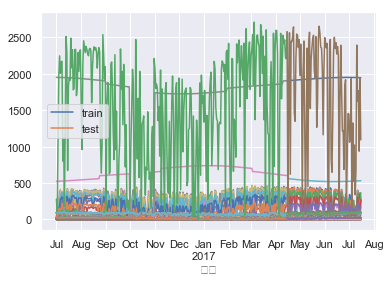

In [13]:
# 기준점 형성(Timestamp)
split_date = pd.Timestamp('2017-04-15')

# Unadjusted feature만 활용해서 dataframe을 만든다
train = solar_revise.loc[:split_date, columns]
test = solar_revise.loc[split_date:, columns]

print(split_date, train.shape, test.shape)

# plot

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [14]:
# scaling

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [15]:
train_sc_df = pd.DataFrame(data=train_sc, columns=columns, index=train.index)
test_sc_df = pd.DataFrame(data=test_sc, columns=columns, index=test.index)

In [16]:
# for shift in range(1, 13):
#     train_sc_df['shift_{}'.format(shift)] = train_sc_df['Scaled'].shift(shift)
#     test_sc_df['shift_{}'.format(shift)] = test_sc_df['Scaled'].shift(shift)

In [17]:
# train, test
X_train_df = train_sc_df.iloc[:, :-1]
y_train_df = train_sc_df.iloc[:, -1:]

X_test_df = test_sc_df.iloc[:, :-1]
y_test_df = test_sc_df.iloc[:, -1:]

# DataFrame -> ndarray
# X_train = X_train_df.values
# y_train = y_train_df.values
# X_test = X_test_df.values
# y_test = y_test_df.values

### Modeling: RNN

In [ ]:
# test

# data = []
# dataset = X_train_df
# length = len(dataset)
# window_size = 7

# for i in range(length):
#     change_data = dataset[i:(i+window_size)]
#     data.append(np.array(change_data))

# test_result = np.array(data)

In [18]:
def dataset_reshape(dataset, window_size=1):
    data = []
    for i in range(len(dataset) - window_size - 1):
        change_data = dataset[i:(i+window_size)]
        data.append(np.array(change_data))
    return np.array(data)

In [19]:
# 2

# 2차원 데이터(size, feature)를 3차원 데이터(size, feature, time)으로.
X_train = dataset_reshape(X_train_df, 7)
y_train = dataset_reshape(y_train_df['충전시간발전량'], 7)

# X_train = X_train_df.values
# y_train = y_train_df.values

X_test = dataset_reshape(X_test_df, 7)
y_test = dataset_reshape(y_test_df['충전시간발전량'], 7)

# X_test = X_test_df.values
# y_test = y_test_df.values

# check shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((281, 7, 82), (281, 7), (85, 7, 82), (85, 7))

In [ ]:
# 1

# 2차원 데이터(size, feature)를 3차원 데이터(size, feature, time)으로.

# X_train_t = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_t = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

# # check shape
# X_train.shape, X_train_t.shape, X_test.shape, X_test_t.shape

In [20]:
from keras.layers import LSTM, Dense, Input, Embedding, Dropout
from keras.models import Sequential
from keras.models import Model
import keras.backend as K
import keras
from keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [21]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
# 손실 이력 객체 생성
history = LossHistory() 
history.init()

In [22]:
# 모델 함수 만들기

def create_model(dropout_rate=0.0):
    
    activation='relu'
    dropout_rate=0.0
    init_mode='uniform'
    optimizer='adam'
    lr=0.01
    momentum=0
    
    #create model
    model = Sequential()
    model.add(LSTM(100, input_shape=(7, 82)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(7))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    return model

In [23]:
%%time

# create model
model = KerasRegressor(build_fn=create_model, epochs=30, batch_size=30)

# Use scikit-learn to grid search
activation = ['relu', 'tahn', 'sigmoid']
optimizer = ['adam', 'SGD', 'RMSprop']
dropout_rate = [0.3, 0.6, 0.9]

# grid search epochs, batch size
epochs = [30, 50]
batch_size = [30]
dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8]
param_grid = dict(epochs=epochs, batch_size=batch_size, dropout_rate=dropout_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=1)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
187/187 [==============================] - 1s 6ms/step - loss: 0.2371 - acc: 0.1444
Epoch 2/30
187/187 [==============================] - 0s 603us/step - loss: 0.1083 - acc: 0.1711
Epoch 3/30
187/187 [==============================] - 0s 620us/step - loss: 0.0754 - acc: 0.1872
Epoch 4/30
187/187 [==============================] - 0s 574us/step - loss: 0.0728 - acc: 0.1818
Epoch 5/30
187/187 [==============================] - 0s 587us/step - loss: 0.0633 - acc: 0.1925
Epoch 6/30
187/187 [==============================] - 0s 619us/step - loss: 0.0577 - acc: 0.2032
Epoch 7/30
187/187 [==============================] - 0s 622us/step - loss: 0.0565 - acc: 0.1818
Epoch 8/30
187/187 [==============================] - 0s 618us/step - loss: 0.0525 - acc: 0.2620
Epoch 9/30
187/187 [==============================] - 0s 609us/step - loss: 0.0499 - acc: 0.2941
Epoch 10/30
187/187 [==============================] - 0s 595us/step - loss: 0.0486 - acc: 0.2941
Epoch 11/30
187/187 [==========

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.0min finished


Epoch 1/50
281/281 [==============================] - 5s 17ms/step - loss: 0.1216 - acc: 0.1388
Epoch 2/50
281/281 [==============================] - 0s 564us/step - loss: 0.0703 - acc: 0.1851
Epoch 3/50
281/281 [==============================] - 0s 569us/step - loss: 0.0574 - acc: 0.1779
Epoch 4/50
281/281 [==============================] - 0s 553us/step - loss: 0.0505 - acc: 0.2100
Epoch 5/50
281/281 [==============================] - 0s 578us/step - loss: 0.0465 - acc: 0.2278
Epoch 6/50
281/281 [==============================] - 0s 594us/step - loss: 0.0436 - acc: 0.2349
Epoch 7/50
281/281 [==============================] - 0s 555us/step - loss: 0.0424 - acc: 0.3025
Epoch 8/50
281/281 [==============================] - 0s 556us/step - loss: 0.0402 - acc: 0.2883
Epoch 9/50
281/281 [==============================] - 0s 590us/step - loss: 0.0384 - acc: 0.2811
Epoch 10/50
281/281 [==============================] - 0s 556us/step - loss: 0.0359 - acc: 0.2811
Epoch 11/50
281/281 [=========

In [24]:
grid_result

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x12479d2e8>,
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'epochs': [30, 50], 'batch_size': [30], 'dropout_rate': [0.0, 0.2, 0.4, 0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [42]:
grid_result.best_estimator_.model.save("lstm_1.h5")

### save models

In [44]:
from keras.models import load_model

lstm_1 = load_model('lstm_1.h5')

In [45]:
lstm_1

### log history

In [46]:
from keras.callbacks import CSVLogger

In [47]:
csv_logger = CSVLogger('training.log')
lstm_1.fit(X_train, y_train, callbacks=[csv_logger])

Epoch 1/1
281/281 [==============================] - 2s 8ms/step - loss: 0.0086 - acc: 0.6228


In [48]:
!cat training.log

epoch,acc,loss
0,0.6227758013480923,0.008644157530096926


In [ ]:
# K.clear_session()

# model = Sequential() # Sequential Model
# model.add(LSTM(100, input_shape=(7, 82))) # (timestamp, feature) 
# model.add(Dropout(0.3))
# model.add(Dense(7)) # output = 1
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=50, batch_size=30, verbose=0, callbacks=[history])

In [51]:
y_pred = lstm_1.predict(X_test)

<Figure size 1440x720 with 0 Axes>

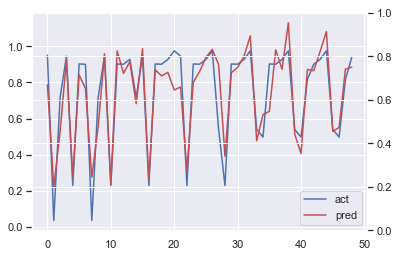

In [59]:
y_test_tuple = (y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5], y_test[6])
y_pred_tuple = (y_pred[0], y_pred[1], y_pred[2], y_pred[3], y_pred[4], y_pred[5], y_pred[6])

plt.figure(figsize=(20, 10))
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.concatenate(y_test_tuple), 'b', label='act')
loss_ax.plot(np.concatenate(y_pred_tuple), 'r', label='pred')

# acc_ax.legend(loc='lower left')
loss_ax.legend(loc='lower right')

plt.show()

In [ ]:
# loss

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### preprocessing

```

#1

    1. 20Hr, 일몰시간, 일출시간, 날짜 : int64 -> float64


#2
```

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
solar_data = solar_raw.copy()
solar_data = solar_data.astype('float32', copy=True)
solar_data.tail()

In [ ]:
X_data = solar_data.drop(['충전시간발전량'], axis=1)
y_data = solar_data['충전시간발전량']
y_data.tail()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=17)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### modeling: scikit-learn
- - -

```
1. x, y train, text dataset 만들기
2. linear regression으로 모델링(statsmodels)
3. 다중회귀
4. 다중 공선성 확인, 제거(PCA)
5. 파라미터 튜닝
```

### scikit-learn

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X_train_df.tail()

In [ ]:
LR = LinearRegression(fit_intercept=True)
model_lr_1 = LR.fit(X_train_df.values, y_train_df.values)

# 성능평가
y_pred = model_lr_1.predict(X_test_df.values)
mse = (np.square(y_pred - y_test_df.values)).mean(axis=0)
mse

In [ ]:
from sklearn.metrics import explained_variance_score

explained_variance_score(y_test_df.values, y_pred)

In [ ]:
# 교차 검증

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_lr_1, X_data, y_data, cv=50, scoring='r2')
scores = np.mean(scores)
scores

### modeling: statsmodels

- 다중공선성 제거

In [ ]:
import statsmodels.api as sm

model_lr_2 = sm.OLS(y_data, X_data)
result_2 = model_lr_2.fit()
result_2.summary()

In [ ]:
formula = "충전시간발전량 ~ "
for column in list(X_data.columns):
    to_add = "scale({}) + ".format(column)
    formula += to_add
formula